## Preprocessing - Introduction

**Gil Levy** and **Liad Levi Raz** (1st notebook)


This notebook is downloading and preprocessing the Simple Questions v2 dataset from Huggingface

The dataset is [Simple Questions v2 dataset from Huggingface](https://huggingface.co/datasets/simple_questions_v2).

It contains IDs of 2 'entities' and a 'relation' between them - which is an answer to a given `question` in the 4th column.
The entities and relations are encoded using the legacy ['Freebase' database](https://en.wikipedia.org/wiki/Freebase_(database)) IDs, for example:

|subject_entity | 	relationship | 	object_entity | 	question|
|---|---|---|---|
|	www.freebase.com/m/0f3xg_	| www.freebase.com/symbols/namesake/named_after	| www.freebase.com/m/0cqt90 | 	Who was the trump ocean club international hotel and tower named after\n |
|	www.freebase.com/m/07f3jg | 	www.freebase.com/people/person/place_of_birth | 	www.freebase.com/m/0565d |	where was sasha vujačić born\n |


As part of preprocessing, we are translating the Freebase IDs using [Google Knowledge Graph API](https://developers.google.com/knowledge-graph) and replacing the 'Subject entity' and the 'Object entity' if they are found in the G.K.G. query (about ~70% of the IDs are found total of 70K entries - which is more than enough for our needs and training computation power capabilities)

The Freebase 'Relation' IDs are kept as is, and eventually we produce 3 dataframes Train,Dev and Test with the following stucture:

|subject_entity | 	relationship | 	object_entity | 	question|
|---|---|---|---|
|E	| /book/written_work/subjects | 	Spiritualism	| what is the book e about |
|The Debt | 	/film/film/country | 	United Kingdom|	what country was the film the debt from |
|	Nobuo Uematsu | 	/music/producer/tracks_produced	 | The Oath	 | what songs have nobuo uematsu produced? | 

As a final product we produce dataframes with two text fields, and add our own 3 special markers `<se>`,`<rel>` and `<oe>` :

|input_text | target_text|
|---|---|
|	\<se\> E \<rel\> /book/written_work/subjects \<oe\>Spiritualism	|what is the book e about|
|	\<se\> The Debt \<rel\> /film/film/country \<oe\>United Kingdom	|what country was the film the debt from|
|	\<se\> Nobuo Uematsu \<rel\> /music/producer/tracks_produced \<oe\>The Oath	|what songs have nobuo uematsu produced?|

The above is used for the project first phase, which is a Seq2Seq generation model for generating questions from the input triplets:

*(entity1,relation,entity2)*-->*Question*

In an additional step we create additional columns to the dataset, with a longer description, by querying the 'long description' of each entity in Google Knowledge Graph API, we store the additional descption of every entity in the dataset for the second phase which is: generating more interesting questions.




The preprocessing and training flow

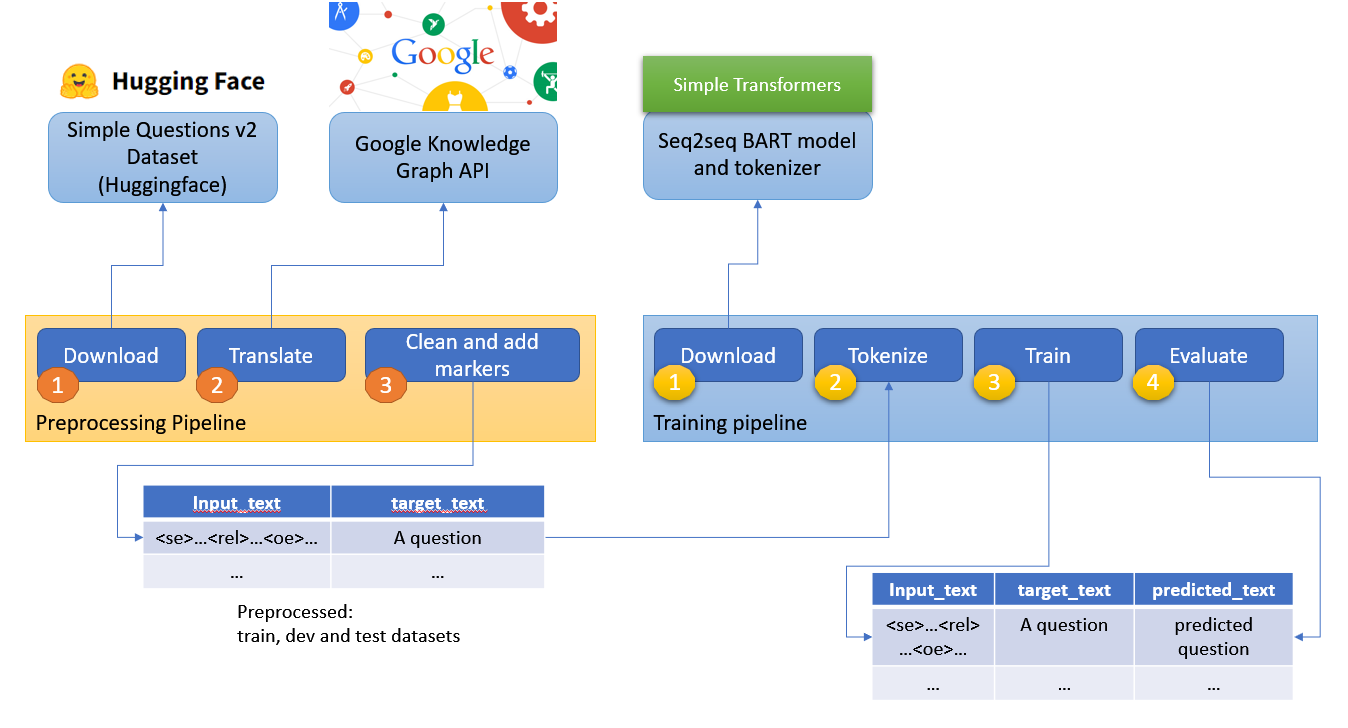

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DRIVE_PATH='/content/drive/MyDrive/2022/S2/3523_Natural_Language_Processing/notebooks/final_proj/'

Mounted at /content/drive


In [ ]:
!pip install -q datasets transformers transformers[sentencepiece] flair pip 

     |████████████████████████████████| 362 kB 7.7 MB/s 
     |████████████████████████████████| 4.4 MB 54.0 MB/s 
     |████████████████████████████████| 140 kB 74.9 MB/s 
     |████████████████████████████████| 212 kB 73.4 MB/s 
     |████████████████████████████████| 101 kB 9.1 MB/s 
     |████████████████████████████████| 1.1 MB 66.9 MB/s 
     |████████████████████████████████| 596 kB 76.2 MB/s 
     |████████████████████████████████| 127 kB 74.9 MB/s 
     |████████████████████████████████| 6.6 MB 43.8 MB/s 
     |████████████████████████████████| 271 kB 72.4 MB/s 
     |████████████████████████████████| 94 kB 4.3 MB/s 
     |████████████████████████████████| 144 kB 79.7 MB/s 
     |████████████████████████████████| 1.2 MB 58.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which 

Download and Patch the "simple questions" preprocessing script
(Fix an issue that was only getting the 'train dataset' and not the Dev and Test ones)

(Uncomment this cell if you want to download and preprocess from scratch)

In [ ]:
# !git clone https://github.com/huggingface/datasets.git
# !cp -rf datasets/datasets/simple_questions_v2/ .
#override with the fixed files
# !cp -rf {DRIVE_PATH}/code/* /content/simple_questions_v2/
# !cp -rf /content/drive/MyDrive/2022/S2/3523_Natural_Language_Processing/notebooks/final_proj/data/arrow/*/*.* /content/data/
# !cp -rf /content/drive/MyDrive/2022/S2/3523_Natural_Language_Processing/notebooks/final_proj/data/anno*.txt /content/datatxt/
# !mv /content/annotated_fb_data_train.txt /content/annotated_fb_data_train.tsv
# !mv /content/annotated_fb_data_valid.txt /content/annotated_fb_data_valid.tsv
# !mv /content/annotated_fb_data_test.txt /content/annotated_fb_data_test.tsv

In [ ]:
import re
import os
import copy 
import random
import warnings
import numpy as np
import pandas as pd

#Pytorch
import torch
import torch.nn as nn

#NLP related
from transformers import BertTokenizer,BertForSequenceClassification,BertModel
pd.set_option("max_colwidth", 1000)

from tqdm.notebook import tqdm
from pprint import pprint
from flair.data import Sentence
from flair.models import SequenceTagger
warnings.filterwarnings('ignore')

In [ ]:
SEED = 42
# torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu' #Good for debugging!
# print('Using device:', device)

Load the dataset splits

In [ ]:
!cp -rf {DRIVE_PATH}/cached_files/*ed_df.csv /content/
!cp -rf {DRIVE_PATH}/cached_files/cleaned_*df.csv /content/

In [ ]:
# copy the cached files directly to target cached location.... instead of download and split each time
!cp -rf {DRIVE_PATH}/cached_files/*.zip .
!unzip -q -n downloads.zip && unzip -q -n simple_questions_v2.zip

In [ ]:
from datasets import list_datasets, load_dataset
sq2_dataset = load_dataset('simple_questions_v2',cache_dir='/content/')
print(sq2_dataset['train'][0])

No config specified, defaulting to: simple_questions_v2/annotated
Reusing dataset simple_questions_v2 (/content/simple_questions_v2/annotated/1.0.0/34f1d3192ae05b8e6aaeb21c2dce2758be2895b862d0a868d3c4266c59948ce4)


  0%|          | 0/3 [00:00<?, ?it/s]

{'id': '0', 'subject_entity': 'www.freebase.com/m/04whkz5', 'relationship': 'www.freebase.com/book/written_work/subjects', 'object_entity': 'www.freebase.com/m/01cj3p', 'question': 'what is the book e about\n'}


In [ ]:
SE1 = sq2_dataset['train'][11]['subject_entity']
SE1

'www.freebase.com/m/0275d7v'

In [ ]:
sq2_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'subject_entity', 'relationship', 'object_entity', 'question'],
        num_rows: 75910
    })
    validation: Dataset({
        features: ['id', 'subject_entity', 'relationship', 'object_entity', 'question'],
        num_rows: 10845
    })
    test: Dataset({
        features: ['id', 'subject_entity', 'relationship', 'object_entity', 'question'],
        num_rows: 21687
    })
})

Train,Validatoin and Test Datasets

In [ ]:
train_ds = sq2_dataset['train']
val_ds = sq2_dataset['validation']
test_ds = sq2_dataset['test']


In [ ]:
PREFIX = 'www.freebase.com'
def get_all_fb_ids(dataset):
  '''
  Extract unique Freebase IDs from the dataset
  '''
  all_ids = []
  for i,item in tqdm(enumerate(dataset)):
    sj = item['subject_entity'].split(PREFIX)[-1]
    oj = item['object_entity'].split(PREFIX)[-1]
    all_ids.append(oj)
    all_ids.append(sj)
  print(len(all_ids), 'unique ids')
  return set(all_ids)

In [ ]:
trn_unique_fb_ids = get_all_fb_ids(train_ds)
val_unique_fb_ids = get_all_fb_ids(val_ds)
tst_unique_fb_ids = get_all_fb_ids(test_ds)

0it [00:00, ?it/s]

151820 unique ids


0it [00:00, ?it/s]

21690 unique ids


0it [00:00, ?it/s]

43374 unique ids


Translating the freebase IDs to Google Knowledge Graph IDs

API: https://kgsearch.googleapis.com/v1/entities:search

In [ ]:
SEP = '<||>'
def translate_batch(batch_ids):
  """Example of Python client calling Knowledge Graph Search API."""
  import json
  import urllib
  import requests

  api_key = open('.api_key').read()
  query = ''
  service_url = 'https://kgsearch.googleapis.com/v1/entities:search'
  all_params = '&limit=150' +  batch_ids
  url = service_url + '?'+'key=' +api_key + all_params
  response = json.loads(urllib.request.urlopen(url).read())
  rows = []
  for element in response['itemListElement']:
    res = element['result']
    try:
      desc = res['detailedDescription']['articleBody']
    except:
      try:
        desc = element['detailedDescription']['articleBody']
      except:
        desc = 'NA'
    row = str(res['@id'].split(':')[-1]+ SEP+ res['name'] + SEP + desc)
    rows.append(row)

  return rows

In [ ]:
def get_batches(lst,n=100):
  return [lst[i:i + n] for i in range(0, len(lst), n)]

def translate_set(set_of_ids):
  i=0
  all_rows = []
  batches = get_batches(list(set_of_ids))
  print(len(batches),'batches')
  for batch in tqdm(batches):
    str_batch_ids = ''
    for item in batch:
      str_batch_ids+='&ids='+ item
    rows = translate_batch(str_batch_ids)
    all_rows.extend(rows)
    i+=1

  return all_rows

## Load or translate Freebase using Google Knowledge Graph API

1. First get all unique IDs from all 3 datasets
2. Create a consolidated dataset with unique IDs

In [ ]:
SKIP_TRANSLATE = os.path.isfile('consolidated_df.csv')
if(SKIP_TRANSLATE):
  consolidated_df = pd.read_csv('consolidated_df.csv',index_col=0)
COLS = ['id','name','desc']
SKIP_TRANSLATE

True

In [ ]:
if(not SKIP_TRANSLATE):
  all_rows = translate_set(trn_unique_fb_ids)
  trn_translated_df = pd.DataFrame([e.split(SEP) for e in all_rows],columns=COLS)
  display(trn_translated_df.head())

In [ ]:
if(not SKIP_TRANSLATE):
  all_rows = translate_set(val_unique_fb_ids)
  val_translated_df = pd.DataFrame([e.split(SEP) for e in all_rows],columns=COLS)
  display(val_translated_df.head())

In [ ]:
if(not SKIP_TRANSLATE):
  all_rows = translate_set(tst_unique_fb_ids)
  tst_translated_df = pd.DataFrame([e.split(SEP) for e in all_rows],columns=COLS)
  display(tst_translated_df.head())

In [ ]:
#create one dictionary of all IDs and translations + detailed description fields (some are NA's)
if(not SKIP_TRANSLATE):
  consolidated_df = trn_translated_df.append(val_translated_df).append(tst_translated_df)
print('num translated unique IDs',len(consolidated_df))
consolidated_df = consolidated_df.drop_duplicates()
consolidated_df.head()

num translated unique IDs 107040


,id,name,desc
0,/m/0kfmv3x,Sydney Lacan Workshop,NaN
1,/m/01b0nhy,Belleville,NaN
2,/m/01cvxf,American International Pictures,"American International Pictures is an American motion picture production label of Metro-Goldwyn-Mayer. In its original operating period, AIP was an independent film production and distribution company known for producing and releasing films from 1955 until 1980, a year after its acquisition by Filmways in 1979.\n"
3,/m/03vl_5,Scorn,Scorn is an English electronic music project. The group was formed in the early 1990s as a project of former Napalm Death members Mick Harris and Nic Bullen.
4,/m/06pj8n,Frances Townsend,"Frances M. ""Fran"" Fragos Townsend is an American lawyer and business executive who served as Homeland Security Advisor to United States President George W."


In [ ]:
if(not SKIP_TRANSLATE):
  trn_translated_df.to_csv('trn_translated_df.csv')
  val_translated_df.to_csv('val_translated_df.csv')
  tst_translated_df.to_csv('tst_translated_df.csv')
  consolidated_df.to_csv('consolidated_df.csv')

In [ ]:
# !mv {DRIVE_PATH}/cached_files/ {DRIVE_PATH}/old_cached_files/ 
# !mkdir -p {DRIVE_PATH}/cached_files/

In [ ]:
if(not SKIP_TRANSLATE):
  !cp -f *ed_df.csv {DRIVE_PATH}/cached_files/

In [ ]:
if(not SKIP_TRANSLATE):
  print(len(trn_unique_fb_ids),len(val_unique_fb_ids),len(tst_unique_fb_ids))
  print(len(trn_translated_df),len(val_translated_df),len(tst_translated_df))

Input example:

{'id': '0', 'subject_entity': 'www.freebase.com/m/04whkz5', 'relationship': 'www.freebase.com/book/written_work/subjects', 'object_entity': 'www.freebase.com/m/01cj3p', 'question': 'what is the book e about\n'}

In [ ]:
def freebase2kg(id):
  try:
    row = consolidated_df[consolidated_df['id']==id]['name'].values[0]
  except:
    return ''
  if(len(row)==0):
    return id
  return row

In [ ]:
freebase2kg('/m/04whkz5'), freebase2kg('/m/01cj3p'), freebase2kg('/m/0cqt90')

('E', 'Spiritualism', 'Donald Trump')

## Preprocess

In [ ]:
%%time

trn_df = pd.DataFrame(train_ds)
trn_df.drop('id',axis=1,inplace=True)
# trn_df.set_index('id',inplace=True)
val_df = pd.DataFrame(val_ds)
val_df.drop('id',axis=1,inplace=True)
tst_df = pd.DataFrame(test_ds)
tst_df.drop('id',axis=1,inplace=True)
# tmp_df = val_df.head(100)
display(val_df.head(5)),len(val_df)

,subject_entity,relationship,object_entity,question
0,www.freebase.com/m/0f3xg_,www.freebase.com/symbols/namesake/named_after,www.freebase.com/m/0cqt90,Who was the trump ocean club international hotel and tower named after\n
1,www.freebase.com/m/07f3jg,www.freebase.com/people/person/place_of_birth,www.freebase.com/m/0565d,where was sasha vujačić born\n
2,www.freebase.com/m/031j8nn,www.freebase.com/music/release/region,www.freebase.com/m/07ssc,What is a region that dead combo was released in\n
3,www.freebase.com/m/0c1cyhd,www.freebase.com/film/director/film,www.freebase.com/m/0wxsz5y,What is a film directed by wiebke von carolsfeld?\n
4,www.freebase.com/m/0fvhc0g,www.freebase.com/music/release/region,www.freebase.com/m/0345h,what country was music for stock exchange released in\n


CPU times: user 10.5 s, sys: 318 ms, total: 10.8 s
Wall time: 10.4 s


In [ ]:
def translate_df(df):
  '''
  Replace the Freebase IDs with the entity "name" from G.K.G. API
  Adds entity relation markers <se> ,  <oe> and <rel>
  '''
  for index, row in tqdm(df.iterrows(),total=len(df)):
      #replace all freebase prefixes in a row
      df.iloc[index] = row.str.replace(PREFIX,'')
      se = freebase2kg(row['subject_entity'])
      row['subject_entity'] =str(se  if se is not '' else None)
      oe = freebase2kg(row['object_entity'])
      row['object_entity'] =str(oe if oe is not '' else None)
      row['relationship'] =row['relationship']

  return df

In [ ]:
SKIP_PREPROCESS = os.path.isfile('cleaned_trn_df.csv')
SKIP_PREPROCESS

True

In [ ]:
%%time

if(not SKIP_PREPROCESS):
  cleaned_trn_df = translate_df(trn_df)
else:
  cleaned_trn_df = pd.read_csv('cleaned_trn_df.csv',index_col=0)

display(cleaned_trn_df.head(5))

,subject_entity,relationship,object_entity,question
0,E,/book/written_work/subjects,Spiritualism,what is the book e about\n
2,The Debt,/film/film/country,United Kingdom,what country was the film the debt from\n
3,Nobuo Uematsu,/music/producer/tracks_produced,The Oath,what songs have nobuo uematsu produced?\n
5,Most of Us Are Sad,/music/recording/artist,Eagles,Which artist recorded most of us are sad?\n
6,Warner Bros. Pictures,/film/production_company/films,Saving Shiloh,what movie is produced by warner bros.\n


CPU times: user 135 ms, sys: 7.98 ms, total: 143 ms
Wall time: 143 ms


In [ ]:
%%time
if(not SKIP_PREPROCESS):
  cleaned_val_df = translate_df(val_df)
else:
  cleaned_val_df = pd.read_csv('cleaned_val_df.csv',index_col=0)  
display(cleaned_val_df.head(5))

,subject_entity,relationship,object_entity,question
1,Sasha Vujačić,/people/person/place_of_birth,Maribor,where was sasha vujačić born\n
3,Wiebke von Carolsfeld,/film/director/film,Stay,What is a film directed by wiebke von carolsfeld?\n
5,Adler University,/location/location/containedby,United States,Where is adler school of professional psychology located?\n
6,John Miltern,/people/person/place_of_birth,New Britain,where was john miltern born\n
7,Vancouver Millionaires,/sports/sports_team/location,Vancouver,what city is vancouver millionaires from?\n


CPU times: user 31.2 ms, sys: 2.94 ms, total: 34.1 ms
Wall time: 31.4 ms


In [ ]:
%%time
if(not SKIP_PREPROCESS):
  cleaned_tst_df = translate_df(tst_df)
else:
  cleaned_tst_df = pd.read_csv('cleaned_tst_df.csv',index_col=0)
display(cleaned_tst_df.head(5))

,subject_entity,relationship,object_entity,question
0,Harder ... Faster,/music/album/genre,Classic rock,Which genre of album is harder.....faster?\n
1,Fearless,/music/album/release_type,Album,what format is fearless\n
2,Alex Golfis,/people/person/place_of_birth,Athens,what city was alex golfis born in\n
3,Phil Hay,/film/writer/film,Clash of the Titans,what film is by the writer phil hay?\n
6,Dublin,/location/location/people_born_here,Mark Kyle,Which equestrian was born in dublin?\n


CPU times: user 45.1 ms, sys: 6.22 ms, total: 51.3 ms
Wall time: 52 ms


In [ ]:
def drop_nans(df,nan_val='None'):
  df = df.replace(nan_val,np.nan).dropna()
  return df

In [ ]:
# cleaned_trn_df = cleaned_trn_df.replace('None',np.nan).dropna()
if(not SKIP_PREPROCESS):
  cleaned_trn_df = drop_nans(cleaned_trn_df)
  cleaned_val_df = drop_nans(cleaned_val_df)
  cleaned_tst_df = drop_nans(cleaned_tst_df)

In [ ]:
#TODO drop all None which cannot be translated
total=sum([len(cleaned_trn_df),len(cleaned_val_df),len(cleaned_tst_df)])
total_orig=sum([len(trn_df),len(val_df),len(tst_df)])
print('Before train:{} \t valid:{} \t test:{}'.format(len(trn_df),len(val_df),len(tst_df)),'\ttotal:',total_orig)
print('After train :{} \t valid:{} \t test:{}'.format(len(cleaned_trn_df),len(cleaned_val_df),len(cleaned_tst_df)),'\ttotal:',total,'({:.2f} of original)'.format(total/total_orig))

Before train:75910 	 valid:10845 	 test:21687 	total: 108442
After train :51779 	 valid:7409 	 test:14882 	total: 74070 (0.68 of original)


In [ ]:
#TODO save the preprocessed DFs
if(not SKIP_PREPROCESS):
  cleaned_trn_df.to_csv('cleaned_trn_df.csv')
  cleaned_val_df.to_csv('cleaned_val_df.csv')
  cleaned_tst_df.to_csv('cleaned_tst_df.csv')
  !cp cleaned_*.csv {DRIVE_PATH}/cached_files/

In [ ]:
SKIP_SPLIT= os.path.isfile('train_14k_df.csv')
SKIP_SPLIT

False

In [ ]:

if(not SKIP_SPLIT):
  SAMPLE_SZ=14000
  split_trn_df = pd.read_csv('cleaned_trn_df.csv',index_col=0)
  split_trn_df = split_trn_df.sample(SAMPLE_SZ,random_state=SEED)
  split_val_df = pd.read_csv('cleaned_val_df.csv',index_col=0)
  split_val_df = split_val_df.sample(1000,random_state=SEED)
  split_tst_df = pd .read_csv('cleaned_tst_df.csv',index_col=0)
  split_tst_df = split_tst_df.sample(2000,random_state=SEED)
else:
  split_trn_df.read_csv('train_14k_df.csv',index_col=0)
  split_val_df.read_csv('val_14k_df.csv',index_col=0)
  split_tst_df.read_csv('test_14k_tst_df.csv',index_col=0)

In [ ]:
len(split_trn_df),len(split_val_df),len(split_tst_df)

(14000, 1000, 2000)

## Show some plots of the relations columns for Train , Dev and Test

TODO show skewness of dataset

In [ ]:
def count_rel(df,title=''):
  # val_df.groupby('relationship').count().plot.bar()
  u_rel=np.unique(df['relationship'],return_counts=True)
  # print(u_rel)
  print(len(u_rel[0]),title + ' unique relations')
  print('most popular relationship:',u_rel[0][np.argmax(u_rel[1])],np.max(u_rel[1]))
  return u_rel

trn_u_rel = count_rel(split_trn_df,'TRAIN')
val_u_rel = count_rel(split_val_df,'VALID')
tst_u_rel = count_rel(split_tst_df,'TEST')

750 TRAIN unique relations
most popular relationship: /people/person/place_of_birth 690
238 VALID unique relations
most popular relationship: /location/location/containedby 53
332 TEST unique relations
most popular relationship: /people/person/nationality 106


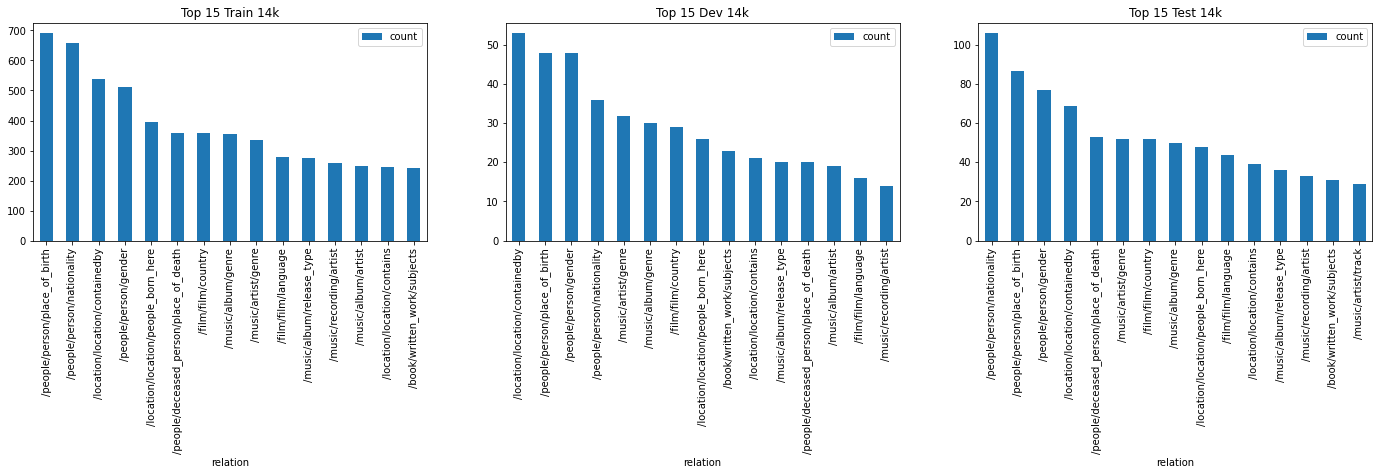

In [ ]:
import matplotlib.pyplot as plt

k=15
f,ax = plt.subplots(1,3,figsize=(24,4))

def np2df(u_rel,k=20):
  d = pd.DataFrame()
  d['relation'] = [str(ur).replace(PREFIX,'') for ur in u_rel[0]] 
  d['count'] = u_rel[1]

  return d.sort_values(by='count',ascending=False)[:k]
a = np2df(trn_u_rel,k)
a.plot.bar(x='relation',y='count',ax=ax[0])
b = np2df(val_u_rel,k)
b.plot.bar(x='relation',y='count',ax=ax[1])
c = np2df(tst_u_rel,k)
c.plot.bar(x='relation',y='count',ax=ax[2])
ax[0].set_title('Top {} Train 14k'.format(k))
ax[1].set_title('Top {} Dev 14k'.format(k))
ax[2].set_title('Top {} Test 14k'.format(k))
plt.show()


## Create seq2seq dataframes (for phase 1)

(for Sequence generation task)


- input_text:

  \<se\> subject entity  \<rel\>  relationship \<oe\> object entity 

- target_text: 

  question

In [ ]:
SPACE = ' '
SE = '<se>'
OE = '<oe>'
REL = '<rel>'
SREL = '<rel>'
EREL = '<rel>'

def build_sentence_column(df):
  # return SE + SPACE + df['subject_entity'] +SPACE + REL + SPACE + df['relationship'].str.replace('/',SPACE) + SPACE + OE + df["object_entity"]
  return SE + SPACE + df['subject_entity'] +SPACE + REL + SPACE + df['relationship'] + SPACE + OE + df["object_entity"]

def create_seq2seq_df(cleaned_df):
    df = pd.DataFrame(columns=['input_text','target_text'])
    df['input_text'] = build_sentence_column(cleaned_df)#.str.replace('_',SPACE)
    df['target_text'] = cleaned_df['question'].str.replace('\n','')
    df = df.reset_index()
    df = df.drop(labels=['index'],axis=1)
    return df


In [ ]:
train_seq2seq_df = create_seq2seq_df(split_trn_df)
train_seq2seq_df

,input_text,target_text
0,<se> Compilation album <rel> /music/album_content_type/albums <oe>iTunes Originals – New Order,what's a compilation album by new order
1,<se> Bay <rel> /geography/geographical_feature_category/features <oe>Carmarthen Bay,What's an example of a bay?
2,<se> Creeping in My Soul <rel> /music/album/genre <oe>Hard rock,what kind of music is on creeping in my soul - ep?
3,<se> 20th century <rel> /book/book_subject/works <oe>Simone de Beauvoir,what books are about the 20th century?
4,<se> San Colombano al Lambro <rel> /location/location/containedby <oe>Lombardy,Where is the location of san colombano al lambro?
...,...,...
13995,<se> Remnants <rel> /film/film/country <oe>United States,which country made the film remnants
13996,<se> Venera <rel> /spaceflight/space_program/missions <oe>Venera 9,What's a mission from the venera space program
13997,<se> Soviet invasion of Manchuria <rel> /time/event/locations <oe>Sakhalin,where is soviet invasion of manchuria located
13998,<se> Amy Martinez <rel> /people/person/gender <oe>Female,what is the gender of amy martinez


In [ ]:
val_seq2seq_df = create_seq2seq_df(split_val_df)
val_seq2seq_df

,input_text,target_text
0,<se> Mysłakowo <rel> /location/location/containedby <oe>Lipno County,what county is mysłakowo located in
1,<se> Old Harmony <rel> /location/location/containedby <oe>Etowah County,in which southern county is old harmony located
2,<se> Grady Cooper <rel> /people/person/place_of_birth <oe>Raleigh,where did grady cooper's life begin
3,<se> Heng Wu <rel> /people/person/profession <oe>Film director,What is Heng Wu's profession
4,<se> Frederick Hastings Rindge House <rel> /architecture/structure/architectural_style <oe>Renaissance architecture,what is the type of architectural style of frederick hastings rindge house?
...,...,...
995,<se> Grzegorz Turnau <rel> /people/person/gender <oe>Male,what is the gender of grzegorz turnau
996,<se> The Jesus and Mary Chain <rel> /music/artist/genre <oe>Post-punk,what genre is the jesus and mary chain
997,"<se> Mehrab Hossain, Jr. <rel> /people/person/gender <oe>Male","what is mehrab hossain, jr.'s gender"
998,<se> Green River Ordinance <rel> /music/artist/track <oe>Baby,what track is by green river ordinance?


In [ ]:
test_seq2seq_df = create_seq2seq_df(split_tst_df)
test_seq2seq_df

,input_text,target_text
0,<se> Teacher <rel> /people/profession/people_with_this_profession <oe>James Sorel-Cameron,Name a notable teacher
1,<se> Debi Gliori <rel> /people/person/place_of_birth <oe>Glasgow,where was debi gliori born
2,<se> Watch Out! <rel> /music/album/genre <oe>Melodic hardcore,What type of music is watch out! classified as
3,<se> James Plimsoll <rel> /people/deceased_person/place_of_death <oe>Hobart,where in australia was james plimsoll's place of death?
4,<se> Chemnitzer Land <rel> /base/aareas/schema/administrative_area/capital <oe>Glauchau,what is the capital of chemnitzer land
...,...,...
1995,"<se> 20th century <rel> /book/book_subject/works <oe>Working class cultures in Britain, 1890-1960",what book on the subject of the 20th century
1996,<se> Frances Schifrin <rel> /people/person/parents <oe>Lalo Schifrin,Who was a parent of frances schifrin
1997,<se> Kirikou and the Wild Beasts <rel> /media_common/netflix_title/netflix_genres <oe>French language,what language is spoken in kirikou and the wild beasts
1998,<se> Goalkeeper <rel> /soccer/football_position/players <oe>Carlos Gomes,who was considered to be the greatest portuguese goalkeeper in football?


In [ ]:
print('Final: train:{} \t valid:{} \t test:{}'.format(len(train_seq2seq_df),len(val_seq2seq_df),len(test_seq2seq_df)))


Final: train:14000 	 valid:1000 	 test:2000


In [ ]:
if(not SKIP_SPLIT):
  train_seq2seq_df.to_csv('train_14k_df.csv')
  val_seq2seq_df.to_csv('val_14k_df.csv')
  test_seq2seq_df.to_csv('test_14k_df.csv')
  !cp *_14k_df.csv {DRIVE_PATH}/data/

## TODO - Create question generation dataframes (for phase 2)

(for generation of more interesting questions from extended 'entities' description)


- input_text:

  \<se\> subject entity  \<rel\>  relationship \<oe\> object entity 

- target_text: 

  question


  We take a shorter version of the description becuase of computational limitations (first sentence)


In [ ]:
!pip install -q flair

     |████████████████████████████████| 401 kB 9.4 MB/s 
     |████████████████████████████████| 19.7 MB 6.9 MB/s 
     |████████████████████████████████| 788 kB 54.0 MB/s 
     |████████████████████████████████| 53 kB 2.2 MB/s 
     |████████████████████████████████| 1.6 MB 44.4 MB/s 
     |████████████████████████████████| 46 kB 4.5 MB/s 
     |████████████████████████████████| 981 kB 25.3 MB/s 
     |████████████████████████████████| 1.2 MB 33.9 MB/s 
     |████████████████████████████████| 199 kB 53.7 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.7 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 3.10.1 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6

In [ ]:
from pprint import pprint
from flair.data import Sentence
from flair.models import SequenceTagger

# load tagger
tagger = SequenceTagger.load("flair/ner-english-large")

Downloading:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

2022-07-02 08:11:27,555 loading file /root/.flair/models/ner-english-large/07301f59bb8cb113803be316267f06ddf9243cdbba92a4c8067ef92442d2c574.554244d3476d97501a766a98078421817b14654496b86f2f7bd139dc502a4f29


Downloading:   0%|          | 0.00/616 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

2022-07-02 08:11:49,419 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>


In [ ]:
all_tags = {}
def add_tags(text):
  sent = Sentence(text)
  tagger.predict(sent)
  texts = {}

  for entity in sent.get_spans('ner'):
      all_tags[entity.tag] = 1
      txt_with_markers = str('<' + entity.tag + '>'+entity.text+'</' + entity.tag + '>').strip()
      texts[entity.text]= txt_with_markers

  for text2replace in texts:
    text = text.replace(text2replace,texts[text2replace])

  return text
#test
add_tags('The Terrible Trio is a group of fictional supervillains appearing in comic books published by DC Comics'),all_tags

('The <ORG>Terrible Trio</ORG> is a group of fictional supervillains appearing in comic books published by <ORG>DC Comics</ORG>',
 {'ORG': 1})

In [ ]:
MIN_LEN=50
p2_consolidated_df = consolidated_df.dropna()
by_dot = [sd.split('.')[0] for sd in p2_consolidated_df['desc']]
by_comma = [sd.split(',')[0] for sd in p2_consolidated_df['desc']]
selected_short = by_dot if ((len(by_dot) > MIN_LEN) and (len(by_dot) < len(by_comma))) else by_comma
p2_consolidated_df['short_desc'] = selected_short#[sd.split('.')[0] for sd in selected_short]

p2_consolidated_df.head()

,id,name,desc,short_desc
2,/m/01cvxf,American International Pictures,"American International Pictures is an American motion picture production label of Metro-Goldwyn-Mayer. In its original operating period, AIP was an independent film production and distribution company known for producing and releasing films from 1955 until 1980, a year after its acquisition by Filmways in 1979.\n",American International Pictures is an American motion picture production label of Metro-Goldwyn-Mayer. In its original operating period
3,/m/03vl_5,Scorn,Scorn is an English electronic music project. The group was formed in the early 1990s as a project of former Napalm Death members Mick Harris and Nic Bullen.,Scorn is an English electronic music project. The group was formed in the early 1990s as a project of former Napalm Death members Mick Harris and Nic Bullen.
4,/m/06pj8n,Frances Townsend,"Frances M. ""Fran"" Fragos Townsend is an American lawyer and business executive who served as Homeland Security Advisor to United States President George W.","Frances M. ""Fran"" Fragos Townsend is an American lawyer and business executive who served as Homeland Security Advisor to United States President George W."
5,/m/05_5s5,William C. deMille,"William Churchill deMille, also spelled de Mille or De Mille, was an American screenwriter and film director from the silent film era through the early 1930s. He was also a noted playwright prior to moving into film. Once he was established in film he specialized in adapting Broadway plays into silent films.",William Churchill deMille
7,/m/0c_1q1,Humid Pampas,"The Humid Pampas is an extensive ecoregion of flat, fertile grassland of loessic origin in Argentina. It has a precipitation average of 900 mm per year, in contrast with the Dry Pampas to the west, which average less than 700 mm.",The Humid Pampas is an extensive ecoregion of flat


In [ ]:
def freebase2kg_extended(id):
  try:
    row = p2_consolidated_df[p2_consolidated_df['id']==id]
  except:
    return ''
  if(len(row)==0):
    return ''
  return row

In [ ]:
freebase2kg_extended('/m/01cvxf')

,id,name,desc,short_desc
2,/m/01cvxf,American International Pictures,"American International Pictures is an American motion picture production label of Metro-Goldwyn-Mayer. In its original operating period, AIP was an independent film production and distribution company known for producing and releasing films from 1955 until 1980, a year after its acquisition by Filmways in 1979.\n",American International Pictures is an American motion picture production label of Metro-Goldwyn-Mayer. In its original operating period


In [ ]:
def translate_df_extended(df):
  '''
  Replace the Freebase IDs with the entity "name" from G.K.G. API
  adds the long description from G.K.G API
  '''
  df_new = pd.DataFrame(columns=df.columns)
  df_new['subject_entity_desc']=[]
  df_new['object_entity_desc']=[]
  for index, row in tqdm(df.iterrows(),total=len(df)):
      # replace all freebase prefixes in a row
      r = row.str.replace(PREFIX,'')
      se = freebase2kg_extended(r['subject_entity'])
      if(len(se)>0):
        r['subject_entity'] = se['name'].values[0]  if se is not '' else None
        r['subject_entity_desc'] =add_tags(str(se['short_desc'].values[0]))  if se is not '' else None
      oe = freebase2kg_extended(r['object_entity'])
      if(len(oe)>0):
        r['object_entity'] =str(oe['name'].values[0] if oe is not '' else None)
        r['object_entity_desc'] =add_tags(str(oe['short_desc'].values[0])) if oe is not '' else None
      r['relationship'] =r['relationship']
      df_new.loc[len(df_new)] = r
  return df_new

In [ ]:
SKIP_PREPROCESS=False

In [ ]:
#taking 20K because some will be dropped because of NaNs - Freebase IDs that are not found
if(not SKIP_PREPROCESS):
  p2_trn_translated_df = translate_df_extended(trn_df[:20000])
else:
  p2_trn_translated_df = pd.read_csv('p2_trn_translated_df.csv',index_col=0)  
display(p2_trn_translated_df.head(5))

  0%|          | 0/20000 [00:00<?, ?it/s]

,subject_entity,relationship,object_entity,question,subject_entity_desc,object_entity_desc
0,/m/04whkz5,/book/written_work/subjects,Spiritualism,what is the book e about\n,NaN,Spiritualism is a movement based on the belief that the spirits of the dead exist and have the ability and the necessary means to communicate with the living.
1,/m/0tp2p24,/music/release_track/release,/m/0sjc7c1,to what release does the release track cardiac arrest come from\n,NaN,NaN
2,The Debt,/film/film/country,United Kingdom,what country was the film the debt from\n,<MISC>The Debt</MISC> is a two-part <MISC>British</MISC> television crime drama film,The <LOC>United Kingdom of Great Britain</LOC> and <LOC>Northern Ireland</LOC>
3,Nobuo Uematsu,/music/producer/tracks_produced,/m/0p600l,what songs have nobuo uematsu produced?\n,<PER>Nobuo Uematsu</PER> is a <MISC>Japanese</MISC> composer and keyboardist best known for his contributions to the <MISC>Final Fantasy</MISC> video game series by <ORG>Square Enix</ORG>.,NaN
4,/m/036p007,/music/release/producers,Swizz Beatz,Who produced eve-olution?\n,NaN,<PER>Kasseem Daoud Dean</PER>


In [ ]:
if(not SKIP_PREPROCESS):
  p2_val_translated_df = translate_df_extended(val_df[:3000])
else:
  p2_val_translated_df = pd.read_csv('p2_val_translated_df.csv',index_col=0)  
display(p2_val_translated_df.head(5))

  0%|          | 0/10845 [00:00<?, ?it/s]

,subject_entity,relationship,object_entity,question,subject_entity_desc,object_entity_desc
0,/m/0f3xg_,/symbols/namesake/named_after,Donald Trump,Who was the trump ocean club international hotel and tower named after\n,NaN,<PER>Donald John Trump</PER> is an <MISC>American</MISC> politician
1,Sasha Vujačić,/people/person/place_of_birth,Maribor,where was sasha vujačić born\n,"Aleksander ""Sasha"" Vujačić is a <MISC>Slovenian</MISC> former professional basketball player. He was selected by the <ORG>Los Angeles Lakers</ORG> in the first round of the 2004 <ORG>NBA</ORG> draft with the 27th overall pick.",<LOC>Maribor</LOC> is the second-largest city in <LOC>Slovenia</LOC> and the largest city of the traditional region of <LOC>Lower Styria</LOC>. It is also the seat of the City Municipality of <LOC>Maribor</LOC>
2,/m/031j8nn,/music/release/region,United Kingdom,What is a region that dead combo was released in\n,NaN,The <LOC>United Kingdom of Great Britain</LOC> and <LOC>Northern Ireland</LOC>
3,Wiebke von Carolsfeld,/film/director/film,Stay,What is a film directed by wiebke von carolsfeld?\n,<PER>Wiebke von Carolsfeld</PER> is a <MISC>German</MISC> <MISC>Canadian</MISC> film director,<MISC>Stay</MISC> is a 2013 film directed by <PER>Wiebke von Carolsfeld</PER>
4,/m/0fvhc0g,/music/release/region,Germany,what country was music for stock exchange released in\n,NaN,<ORG>Germany</ORG>


In [ ]:
if(not SKIP_PREPROCESS):
  p2_tst_translated_df = translate_df_extended(tst_df[:5000])
else:
  p2_tst_translated_df = pd.read_csv('p2_tst_translated_df.csv',index_col=0)  
display(p2_tst_translated_df.head(5))

  0%|          | 0/21687 [00:00<?, ?it/s]

,subject_entity,relationship,object_entity,question,subject_entity_desc,object_entity_desc
0,Harder ... Faster,/music/album/genre,Classic rock,Which genre of album is harder.....faster?\n,<MISC>Harder ... Faster</MISC> is the eighth studio album by <MISC>Canadian</MISC> rock band <ORG>April Wine</ORG>,Classic rock is a <LOC>US</LOC> radio format which developed from the album-oriented rock format in the early 1980s. In the <LOC>United States</LOC>
1,Fearless,/music/album/release_type,Album,what format is fearless\n,<MISC>Fearless</MISC> is the 1988 debut album by <MISC>British</MISC> pop group <ORG>Eighth Wonder</ORG>. It is the group's only <LOC>UK</LOC> album release,An album is a collection of audio recordings issued on compact disc
2,/m/0wzc58l,/people/person/place_of_birth,Athens,what city was alex golfis born in\n,NaN,<LOC>Athens</LOC> is the capital city of <LOC>Greece</LOC>. With a population close to 4 million it is the largest city in <LOC>Greece</LOC>
3,Phil Hay,/film/writer/film,Clash of the Titans,what film is by the writer phil hay?\n,<PER>Phil Hay</PER> is an <MISC>American</MISC> screenwriter. His credits include <MISC>Destroyer</MISC>,<MISC>Clash of the Titans</MISC> is a 2010 action fantasy film and remake of the 1981 film of the same name produced by <ORG>Metro-Goldwyn-Mayer</ORG>. The story is very loosely based on the <MISC>Greek</MISC> myth of <PER>Perseus</PER>.
4,Roger Marquis,/people/deceased_person/place_of_death,/m/0tzls,Where did roger marquis die\n,<PER>Roger Julian Marquis</PER> was an <MISC>American</MISC> professional baseball player who appeared in one <ORG>Major League Baseball</ORG> game and registered one at bat with the 1955 <ORG>Baltimore Orioles</ORG>.,NaN


In [ ]:
SKIP_PREPROCESS=False

In [ ]:
# cleaned_trn_df = cleaned_trn_df.replace('None',np.nan).dropna()
if(not SKIP_PREPROCESS):
  p2_trn_translated_df = drop_nans(p2_trn_translated_df,nan_val='NaN')
  p2_val_translated_df = drop_nans(p2_val_translated_df,nan_val='NaN')
  p2_tst_translated_df = drop_nans(p2_tst_translated_df,nan_val='NaN')

In [ ]:
total=sum([len(p2_trn_translated_df),len(p2_val_translated_df),len(p2_tst_translated_df)])
total_orig=sum([len(trn_df),len(val_df),len(tst_df)])
print('P2 Before train:{} \t valid:{} \t test:{}'.format(len(trn_df),len(val_df),len(tst_df)),'\ttotal:',total_orig)
print('P2 After train :{} \t valid:{} \t test:{}'.format(len(p2_trn_translated_df),len(p2_val_translated_df),len(p2_tst_translated_df)),'\ttotal:',total,'({:.2f} of original)'.format(total/total_orig))

P2 Before train:75910 	 valid:10845 	 test:21687 	total: 108442
P2 After train :9719 	 valid:5192 	 test:10478 	total: 25389 (0.23 of original)


In [ ]:
# save the phase 2 preprocessed DFs
if(not SKIP_PREPROCESS):
  p2_trn_translated_df.to_csv('p2_trn_translated_df.csv')
  p2_val_translated_df.to_csv('p2_val_translated_df.csv')
  p2_tst_translated_df.to_csv('p2_tst_translated_df.csv')
  !cp p2_*.csv {DRIVE_PATH}/cached_files/

In [ ]:
def build_input_column(df):
  return df['subject_entity_desc'] +SPACE + SREL + SPACE + df['relationship'] + SPACE + EREL + df["object_entity_desc"]
  # return SE + SPACE + df['subject_entity_desc'] +SPACE + REL + SPACE + df['relationship'] + SPACE + OE + df["object_entity_desc"]

def create_seq2seq_df(cleaned_df):
    df = pd.DataFrame(columns=['input_text','target_text'])
    df['input_text'] = build_input_column(cleaned_df)
    df['target_text'] = cleaned_df['question'].str.replace('\n','')
    df = df.reset_index()
    df = df.drop(labels=['index'],axis=1)
    return df
# if(not SKIP_PREPROCESS):

p2_train_seq2seq_df = create_seq2seq_df(p2_trn_translated_df)
p2_val_seq2seq_df = create_seq2seq_df(p2_val_translated_df)
p2_test_seq2seq_df = create_seq2seq_df(p2_tst_translated_df)
p2_train_seq2seq_df.head()

,input_text,target_text
0,<MISC>The Debt</MISC> is a two-part <MISC>British</MISC> television crime drama film <rel> /film/film/country <rel>The <LOC>United Kingdom of Great Britain</LOC> and <LOC>Northern Ireland</LOC>,what country was the film the debt from
1,Warner Bros. Pictures is an <MISC>American</MISC> film production and distribution company of the Warner Bros. Pictures Group division of Warner Bros. The studio is the flagship producer of live-action feature films within the Warner Bros. Pictures Group unit <rel> /film/production_company/films <rel><MISC>Saving Shiloh</MISC> is a 2006 <MISC>American</MISC> family drama film directed by <PER>Sandy Tung</PER>,what movie is produced by warner bros.
2,<LOC>Columbus</LOC> is the state capital and the most populous city in the <LOC>U.S.</LOC> state of <LOC>Ohio</LOC>. With a population of 905 <rel> /travel/travel_destination/tourist_attractions <rel><LOC>Nationwide Arena</LOC> is a multipurpose arena in <LOC>Columbus</LOC>,what's there to see in columbus
3,<LOC>Detroit</LOC> is the largest city in the <LOC>U.S.</LOC> state of <LOC>Michigan</LOC>. It is also the largest <LOC>U.S.</LOC> city on the <LOC>United States</LOC>–<LOC>Canada</LOC> border <rel> /location/location/people_born_here <rel><PER>James Moss</PER>,who is a musician born in detroit
4,<ORG>RYNA</ORG> were a rock band from <LOC>Manchester</LOC> <rel> /music/artist/origin <rel><LOC>Manchester</LOC> is a city in Greater <LOC>Manchester</LOC>,Which city did the artist ryna originate in


In [ ]:
if(not SKIP_PREPROCESS):
  p2_train_seq2seq_df.to_csv('p2_train_seq2seq_df.csv')
  p2_val_seq2seq_df.to_csv('p2_val_seq2seq_df.csv')
  p2_test_seq2seq_df.to_csv('p2_test_seq2seq_df.csv')
  !cp p2_*.csv {DRIVE_PATH}/data/p2/

In [ ]:
len(p2_train_seq2seq_df),len(p2_val_seq2seq_df),len(p2_test_seq2seq_df)

(9719, 5192, 10478)

In [ ]:
display(p2_train_seq2seq_df)


,input_text,target_text
0,<MISC>The Debt</MISC> is a two-part <MISC>British</MISC> television crime drama film <rel> /film/film/country <rel>The <LOC>United Kingdom of Great Britain</LOC> and <LOC>Northern Ireland</LOC>,what country was the film the debt from
1,Warner Bros. Pictures is an <MISC>American</MISC> film production and distribution company of the Warner Bros. Pictures Group division of Warner Bros. The studio is the flagship producer of live-action feature films within the Warner Bros. Pictures Group unit <rel> /film/production_company/films <rel><MISC>Saving Shiloh</MISC> is a 2006 <MISC>American</MISC> family drama film directed by <PER>Sandy Tung</PER>,what movie is produced by warner bros.
2,<LOC>Columbus</LOC> is the state capital and the most populous city in the <LOC>U.S.</LOC> state of <LOC>Ohio</LOC>. With a population of 905 <rel> /travel/travel_destination/tourist_attractions <rel><LOC>Nationwide Arena</LOC> is a multipurpose arena in <LOC>Columbus</LOC>,what's there to see in columbus
3,<LOC>Detroit</LOC> is the largest city in the <LOC>U.S.</LOC> state of <LOC>Michigan</LOC>. It is also the largest <LOC>U.S.</LOC> city on the <LOC>United States</LOC>–<LOC>Canada</LOC> border <rel> /location/location/people_born_here <rel><PER>James Moss</PER>,who is a musician born in detroit
4,<ORG>RYNA</ORG> were a rock band from <LOC>Manchester</LOC> <rel> /music/artist/origin <rel><LOC>Manchester</LOC> is a city in Greater <LOC>Manchester</LOC>,Which city did the artist ryna originate in
...,...,...
9714,<LOC>Washington Pass</LOC> and <LOC>Rainy Pass</LOC> are two mountain passes on <LOC>State Route 20</LOC> in the <LOC>North Cascades</LOC> mountains of <LOC>Washington state</LOC>. <LOC>Rainy Pass</LOC> is about 4 miles to the west of <LOC>Washington Pass</LOC>. <rel> /location/location/containedby <rel><LOC>Chelan County</LOC> is a county in the <LOC>U.S.</LOC> state of <LOC>Washington</LOC>. As of the 2020 census,what county is washington pass a part
9715,"<PER>Kandice Melonakos</PER> <rel> /music/artist/genre <rel>Alternative rock is a category of rock music that emerged from the independent music underground of the 1970s and became widely popular in the 1990s. ""Alternative"" refers to the genre's distinction from mainstream or commercial rock or pop music.",what type of music does lola blanc make
9716,<MISC>Toki</MISC> is a run and gun platform game released in arcades in <LOC>Japan</LOC> in 1989 by <ORG>TAD Corporation</ORG>. It was published in <LOC>North America</LOC> by <ORG>Fabtek</ORG>. Designed by <PER>Akira Sakuma</PER> <rel> /cvg/computer_videogame/cvg_genre <rel>An action game is a video game genre that emphasizes physical challenges,what genre of game is toki?
9717,"<PER>Brad Anderson</PER> is an <MISC>American</MISC> film director <rel> /tv/tv_director/episodes_directed <rel>""<MISC>The Cost</MISC>"" is the tenth episode of the first season of the <ORG>HBO</ORG> original series",what episode is directed by brad anderson


In [ ]:
display(p2_val_seq2seq_df)


,input_text,target_text
0,"Aleksander ""Sasha"" Vujačić is a <MISC>Slovenian</MISC> former professional basketball player. He was selected by the <ORG>Los Angeles Lakers</ORG> in the first round of the 2004 <ORG>NBA</ORG> draft with the 27th overall pick. <rel> /people/person/place_of_birth <rel><LOC>Maribor</LOC> is the second-largest city in <LOC>Slovenia</LOC> and the largest city of the traditional region of <LOC>Lower Styria</LOC>. It is also the seat of the City Municipality of <LOC>Maribor</LOC>",where was sasha vujačić born
1,<PER>Wiebke von Carolsfeld</PER> is a <MISC>German</MISC> <MISC>Canadian</MISC> film director <rel> /film/director/film <rel><MISC>Stay</MISC> is a 2013 film directed by <PER>Wiebke von Carolsfeld</PER>,What is a film directed by wiebke von carolsfeld?
2,<ORG>Adler University</ORG> is a private not-for-profit university <rel> /location/location/containedby <rel>The <LOC>United States of America</LOC>,Where is adler school of professional psychology located?
3,<PER>John Miltern</PER> was an actor in theater and films in the <LOC>United States</LOC>. He was in the <ORG>Broadway</ORG> play <MISC>Yellow Jack</MISC>. He was also in <PER>Channing Pollock</PER>'s play <MISC>Roads of Destiny</MISC>. Another of his stage performances was described as manly and always sympathetic.\n <rel> /people/person/place_of_birth <rel><LOC>New Britain</LOC> is a city in <LOC>Hartford County</LOC>,where was john miltern born
4,The <ORG>Vancouver Millionaires</ORG> were a professional ice hockey team that competed in the <ORG>Pacific Coast Hockey Association</ORG> and the <ORG>Western Canada Hockey League</ORG> between 1911 and 1926. <rel> /sports/sports_team/location <rel><LOC>Vancouver</LOC> is a major city in western <LOC>Canada</LOC>,what city is vancouver millionaires from?
...,...,...
5187,<PER>Herby Fortunat</PER> is a <MISC>Congolese</MISC> former professional footballer who played as a forward. <rel> /soccer/football_player/position_s <rel>Forwards are the players on an association football team who play nearest to the opposing team's goal,which position did herby fortunat play in football?
5188,<LOC>Rim Drive</LOC> is a scenic highway in <LOC>Crater Lake National Park</LOC> in southern <LOC>Oregon</LOC> <rel> /location/location/containedby <rel><LOC>Crater Lake National Park</LOC> is an <MISC>American</MISC> national park located in southern <LOC>Oregon</LOC>. Established in 1902,Where is rim drive historic district located
5189,<PER>Jonathan <PER>Seda</PER></PER> is an <MISC>American</MISC> actor. <PER>Seda</PER> was an amateur boxer who auditioned for and was given a role in the 1992 boxing film <MISC>Gladiator</MISC>.\nHe played the role of <PER>Chris Pérez</PER> alongside <PER>Jennifer Lopez</PER> in the movie <MISC>Selena</MISC> <rel> /people/person/place_of_birth <rel><ORG>Manhattan</ORG>,where was jon seda given birth
5190,<PER>Nikolaj <PER>Frobenius</PER></PER> is a <MISC>Norwegian</MISC> novelist and screen writer.\n<PER>Frobenius</PER> was born in <LOC>Oslo</LOC> <rel> /people/person/profession <rel>A novelist is an author or writer of novels,What is nikolaj frobenius's profession?


In [ ]:
display(p2_test_seq2seq_df)

,input_text,target_text
0,<MISC>Harder ... Faster</MISC> is the eighth studio album by <MISC>Canadian</MISC> rock band <ORG>April Wine</ORG> <rel> /music/album/genre <rel>Classic rock is a <LOC>US</LOC> radio format which developed from the album-oriented rock format in the early 1980s. In the <LOC>United States</LOC>,Which genre of album is harder.....faster?
1,<MISC>Fearless</MISC> is the 1988 debut album by <MISC>British</MISC> pop group <ORG>Eighth Wonder</ORG>. It is the group's only <LOC>UK</LOC> album release <rel> /music/album/release_type <rel>An album is a collection of audio recordings issued on compact disc,what format is fearless
2,<PER>Phil Hay</PER> is an <MISC>American</MISC> screenwriter. His credits include <MISC>Destroyer</MISC> <rel> /film/writer/film <rel><MISC>Clash of the Titans</MISC> is a 2010 action fantasy film and remake of the 1981 film of the same name produced by <ORG>Metro-Goldwyn-Mayer</ORG>. The story is very loosely based on the <MISC>Greek</MISC> myth of <PER>Perseus</PER>.,what film is by the writer phil hay?
3,<LOC>Dublin</LOC> is the capital and largest city of <LOC>Ireland</LOC>. Situated on a bay on the east coast <rel> /location/location/people_born_here <rel><PER>Mark Kyle</PER> is an <MISC>Irish</MISC> <MISC>Olympic</MISC> eventing rider. Representing <LOC>Ireland</LOC>,Which equestrian was born in dublin?
4,Action fiction is the literary genre that includes spy novels <rel> /tv/tv_genre/programs <rel><MISC>Genji Tsūshin Agedama</MISC> is a <MISC>Japanese</MISC> anime series produced by <ORG>NAS</ORG> and <ORG>TV Tokyo</ORG> and animated by <ORG>Studio Gallop</ORG>. The series aired on <ORG>TV Tokyo</ORG> from 1991 to 1992.,What is a tv action show?
...,...,...
10473,<PER>Gunnar Johansen</PER> was a <MISC>Danish-born</MISC> pianist and composer. He was one of the chief proponents of the music of <PER>Ferruccio Busoni</PER> <rel> /people/person/place_of_birth <rel><LOC>Copenhagen</LOC> is the capital and most populous city of <LOC>Denmark</LOC>. As of 1 January 2022,Where was gunnar johansen born in Denmark?
10474,<LOC>Fontana</LOC> is a city in <LOC>San Bernardino County</LOC> <rel> /location/location/containedby <rel><LOC>California</LOC> is a state in the <LOC>Western United States</LOC>. <LOC>California</LOC> borders <LOC>Oregon</LOC> to the north,where in the us is fontana located
10475,<PER>Doctor Faustus</PER> is a supervillain appearing in <MISC>American</MISC> comic books published by <ORG>Marvel Comics</ORG>. The character is depicted usually as an adversary of <PER>Captain America</PER>. <rel> /fictional_universe/fictional_character/character_created_by <rel><PER>Jack Kirby</PER> was an <MISC>American</MISC> comic book artist,who was the creator of the fictional character doctor faustus
10476,<ORG>Oklahoma City</ORG> <rel> /location/location/events <rel>The 1977 <MISC><MISC>NCAA Division I</MISC> Basketball Tournament</MISC> involved 32 <MISC>American</MISC> schools playing in single-elimination play to determine the <MISC>National Champion of Men</MISC>'s <MISC>NCAA Division I</MISC> college basketball.,what's a college sporting event that took place in oklahoma city


In [ ]:
all_tags

{'LOC': 1, 'MISC': 1, 'ORG': 1, 'PER': 1}